# **Time Series Forecasting of Carbon Dioxide Emissions by Electricity Generation in USA.**

In [ ]:
!pip install statsmodels==0.12.2
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


     |████████████████████████████████| 9.5MB 9.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
#Converting the provided into timeseries data by parsing the indexes to date time
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_csv("/content/MER_T11_01-1985.csv", parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse)

In [ ]:
#shape of dataset
print(df.shape)
df.head()


(465, 4)


,MSN,Value,Description,Unit
YYYYMM,,,,
1985-01-01,NNTCEUS,113.099,"Natural Gas, Excluding Supplemental Gaseous Fu...",Million Metric Tons of Carbon Dioxide
1985-02-01,NNTCEUS,115.891,"Natural Gas, Excluding Supplemental Gaseous Fu...",Million Metric Tons of Carbon Dioxide
1985-03-01,NNTCEUS,92.664,"Natural Gas, Excluding Supplemental Gaseous Fu...",Million Metric Tons of Carbon Dioxide
1985-04-01,NNTCEUS,77.586,"Natural Gas, Excluding Supplemental Gaseous Fu...",Million Metric Tons of Carbon Dioxide
1985-05-01,NNTCEUS,61.334,"Natural Gas, Excluding Supplemental Gaseous Fu...",Million Metric Tons of Carbon Dioxide


In [ ]:
emission_sources= df['Description'].unique()

In [ ]:
#High level statistics of numerical attributes
print(df.describe())
#Features in dataset
print(df.columns)

             Value
count   465.000000
mean    187.369497
std     301.947493
min      50.210000
25%      85.110000
50%     102.297000
75%     125.362000
max    1693.720000
Index(['MSN', 'Value', 'Description', 'Unit'], dtype='object')


In [ ]:
#checking for null values
df['Value'].isna().sum()

0

In [ ]:
#time series data after removing total energy emissions of each year
time_series= df[pd.Series(df.index).notnull().values]
print(time_series.shape)

(430, 4)


In [ ]:
time_series.drop(['MSN','Description','Unit'],axis=1,inplace=True)
Energy_source_NaturalGas_New= time_series.copy()
time_series.head()

,Value
YYYYMM,
1985-01-01,113.099
1985-02-01,115.891
1985-03-01,92.664
1985-04-01,77.586
1985-05-01,61.334


In [ ]:
#extracting month and year from data to create new features
Energy_source_NaturalGas_New['Year-month']= pd.to_datetime(time_series.index)
Energy_source_NaturalGas_New['Year']=Energy_source_NaturalGas_New['Year-month'].dt.year
Energy_source_NaturalGas_New['Month']=Energy_source_NaturalGas_New['Year-month'].dt.month

In [ ]:
Energy_source_NaturalGas_New.head()

,Value,Year-month,Year,Month
YYYYMM,,,,
1985-01-01,113.099,1985-01-01,1985,1
1985-02-01,115.891,1985-02-01,1985,2
1985-03-01,92.664,1985-03-01,1985,3
1985-04-01,77.586,1985-04-01,1985,4
1985-05-01,61.334,1985-05-01,1985,5


In [ ]:
#Years of Co2 emission
print(Energy_source_NaturalGas_New['Year'].unique())
print(len(Energy_source_NaturalGas_New['Year'].unique()))

[1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998
 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020]
36


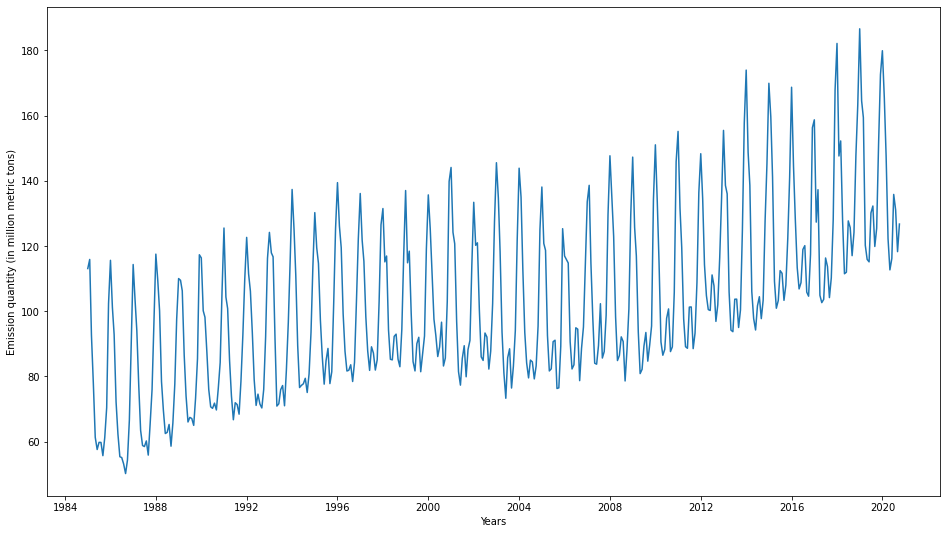

In [ ]:
fig = plt.figure(figsize = (16,9))
plt.plot(time_series.index,time_series['Value'])
plt.xlabel('Years')
plt.ylabel('Emission quantity (in million metric tons)')
plt.show()

Conclusion:


*   Increasing trend- Probably duet to increase in consumption of natural gas for electricity generation
*   Seasonality with period(m=12)
*   There are two seasonal peaks describing weather related fluctuations in energy demand.
*   Seasonal fluctuations are constant.(Suggesting additive decomposition is favorable.)
*   reason behind second small peak in a season?
*   constant value of emissions between period 2000-2006, possibly due to energy/environment related global awareness and policies.







**Correlogram - ACF Plot**

In [ ]:
def plotACF(ts):
  plot_acf(ts,alpha=0.05)
  pyplot.show()

In [ ]:
def plotPACF(ts):
  plot_pacf(ts,alpha=0.05)
  pyplot.show()

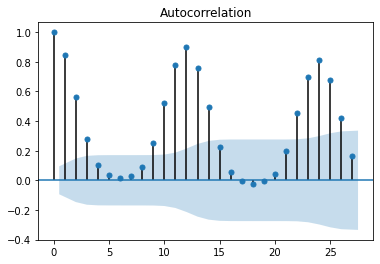

In [ ]:
plotACF(time_series['Value'])



*   There is significant correlation between Yt and it lags.
*   Seasonality of period(m=12) exists.
*   Values of lag1, lag2, lag3... are also significant suggesting trend in time series.





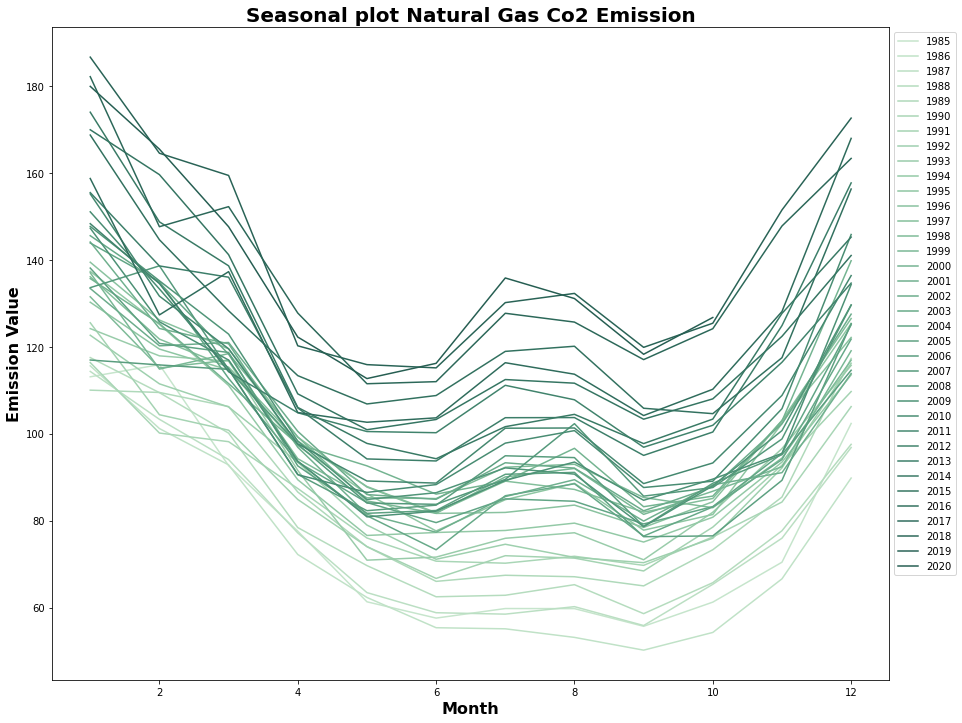

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
palette = sns.color_palette("ch:2.5,-.2,dark=.3",36)
sns.lineplot(Energy_source_NaturalGas_New['Month'], Energy_source_NaturalGas_New['Value'], hue=Energy_source_NaturalGas_New['Year'],palette=palette)
ax.set_title('Seasonal plot Natural Gas Co2 Emission', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Emission Value', fontsize = 16, fontdict=dict(weight='bold'))
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()



*   This plot confirms our above finding of seasonality existence.
*   The emission of Co2 is maximum in the year begining i.e in january possibly due to high electricity consumption for household and commercial purposes.
*   The small peak arrives again between the month 6-8 i.e june- august, again due increase in electricity consumption during summer season.





In [ ]:
#Helper function to plot moving average
def check_stationarity_graphically(ts):
  t_s= pd.DataFrame()
  t_s['Rmean'] = ts.rolling(12).mean()
  t_s['Rstdv'] = ts.rolling(12).var()
  t_s['Rstdv'].replace(np.nan,0)
  t_s['Rmean'].replace(np.nan,0)
  fig = plt.figure(figsize = (16,9))
  plt.plot(time_series.index,ts,label='Original Data')
  plt.plot(time_series.index,t_s['Rmean'],label='Rolling Mean')
  plt.plot(time_series.index,t_s['Rstdv'],label='Rolling Variance')
  plt.legend(loc='best', fontsize = 25)
  plt.show()  

**Transformation**

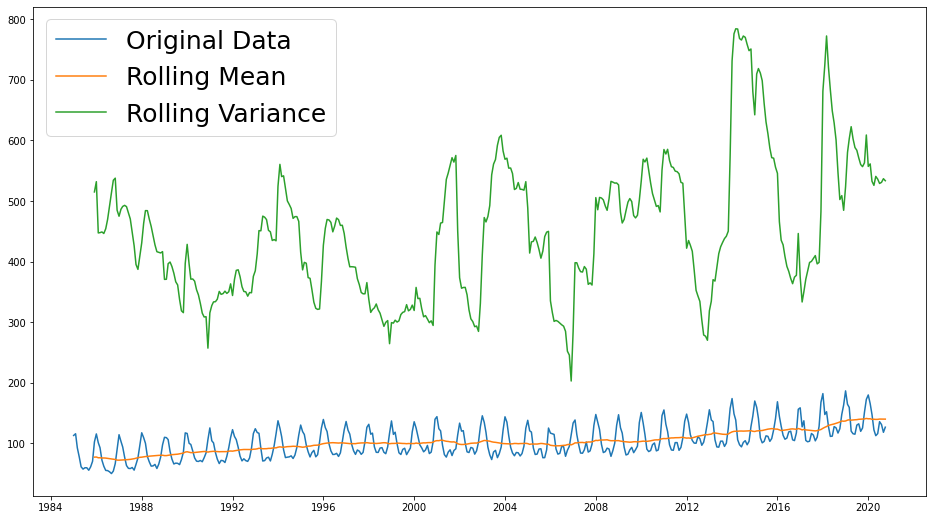

In [ ]:
#Plotting moving average and variance before transformation
check_stationarity_graphically(Energy_source_NaturalGas_New['Value'])


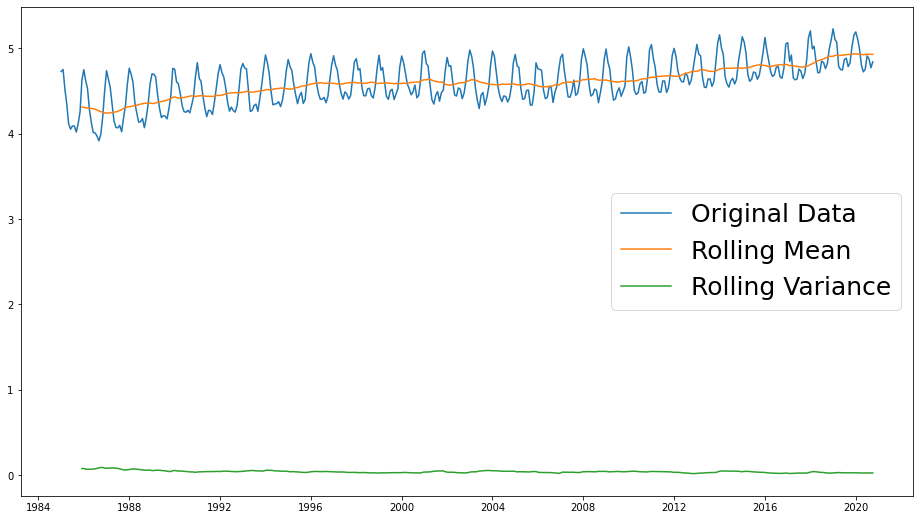

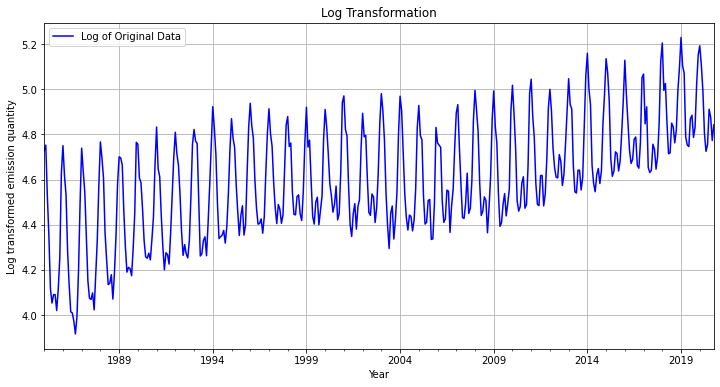

In [ ]:
Energy_source_NaturalGas_New['Log'] = np.log(Energy_source_NaturalGas_New['Value'])
Energy_source_NaturalGas_New['Log'].replace(np.nan,0)
check_stationarity_graphically(Energy_source_NaturalGas_New['Log'])
Energy_source_NaturalGas_New['Log'].plot(figsize=(12,6), legend=True, label = 'Log of Original Data', grid=True,xlabel="Year",ylabel="Log transformed emission quantity",  title='Log Transformation', color='blue')
plt.show()

**TimeSeries Decomposition**

Classical Decomposition

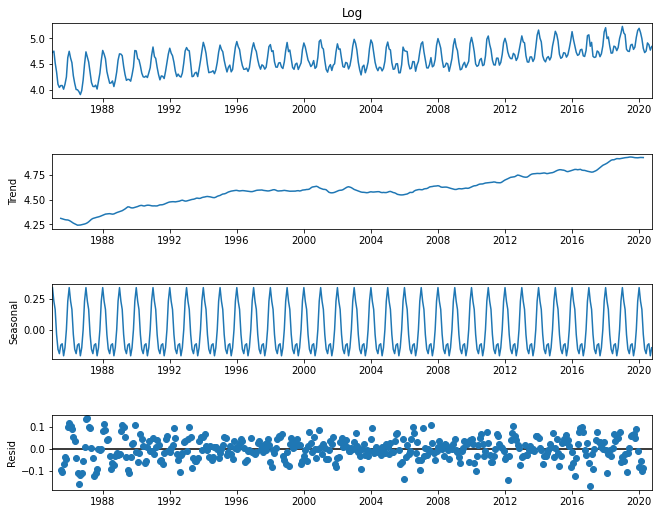

In [ ]:
classical_decomposition = seasonal_decompose(Energy_source_NaturalGas_New['Log'], model='additive')
fig = classical_decomposition.plot();
fig.set_size_inches(10,8)
plt.show()

STL Decomposition

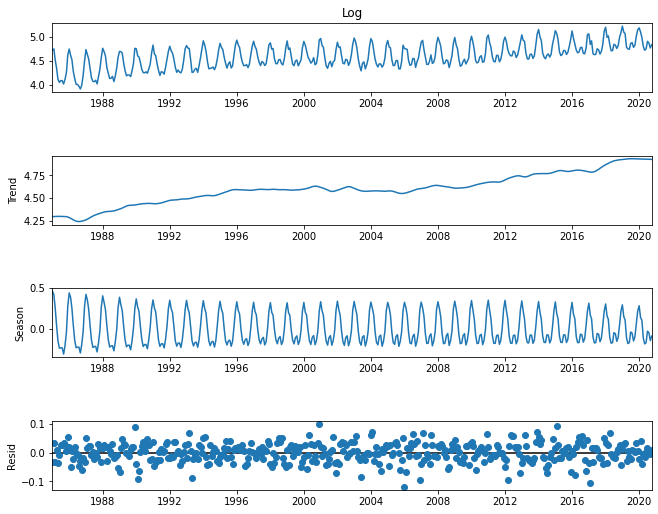

In [ ]:
stl_decomposition = STL(Energy_source_NaturalGas_New['Log'], seasonal= 11)
res = stl_decomposition.fit()
fig = res.plot()
fig.set_size_inches(10,8)
plt.show()

**Checking Stationary using Graph**

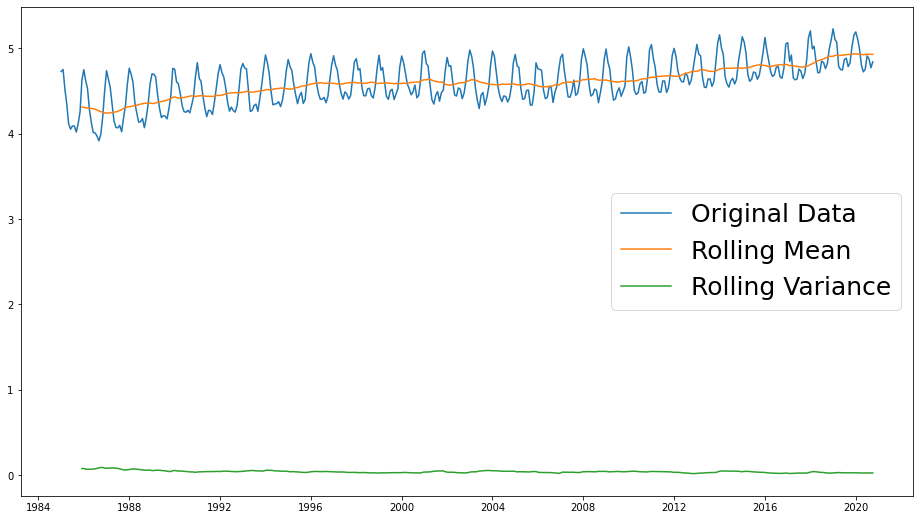

In [ ]:
check_stationarity_graphically(Energy_source_NaturalGas_New['Log'])

**Checking Stationarity using ADF/KPSS**

**KPSS Test**


*   The null hypothesis is that the data are
stationary, and we look for evidence that the null hypothesis is false.


*   Null Hypothesis: The process is trend stationary.
*   Alternate Hypothesis: The series has a unit root (series is not stationary)


*   Small p-values (e.g., less than 0.05) suggest that differencing is
required



In [ ]:
def check_stationarity_KPSSTest(ts): 
  kpsstest = kpss(ts)
  kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
  for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
  print(kpss_output)

In [ ]:
check_stationarity_KPSSTest(Energy_source_NaturalGas_New['Log'])

Test Statistic            1.914572
p-value                   0.010000
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


**ADF Test**

*   Null Hypothesis: The series has a unit root (value of a =1)
*   Alternate Hypothesis: The series has no unit root.



In [ ]:
def check_stationarity_ADFTest(ts):
  adftest = adfuller(ts)
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print (adfoutput)

In [ ]:
check_stationarity_ADFTest(Energy_source_NaturalGas_New['Log'])

Test Statistic                  -0.653386
p-value                          0.858457
#Lags Used                      15.000000
Number of Observations Used    414.000000
Critical Value (1%)             -3.446244
Critical Value (5%)             -2.868547
Critical Value (10%)            -2.570502
dtype: float64


Result: Both test suggest that timeseries is not stationary



*   This clears our understanding that seasonality of constant magnitude variation.
*   We need to check for stationarity data using KPSS/ADF test and visual inspection.



**Splitting data into train,test and forecast**


*   Train-1985-2011
*   Test- 2012-2017
*   Forecast- 2018-2020





In [ ]:
train= Energy_source_NaturalGas_New.iloc[:324]
test= Energy_source_NaturalGas_New.iloc[324:396]
forecast_validate= Energy_source_NaturalGas_New.iloc[396:430]

**Exopential smoothing methods for forecasting**

**Simple Exponential Smoothing Method**

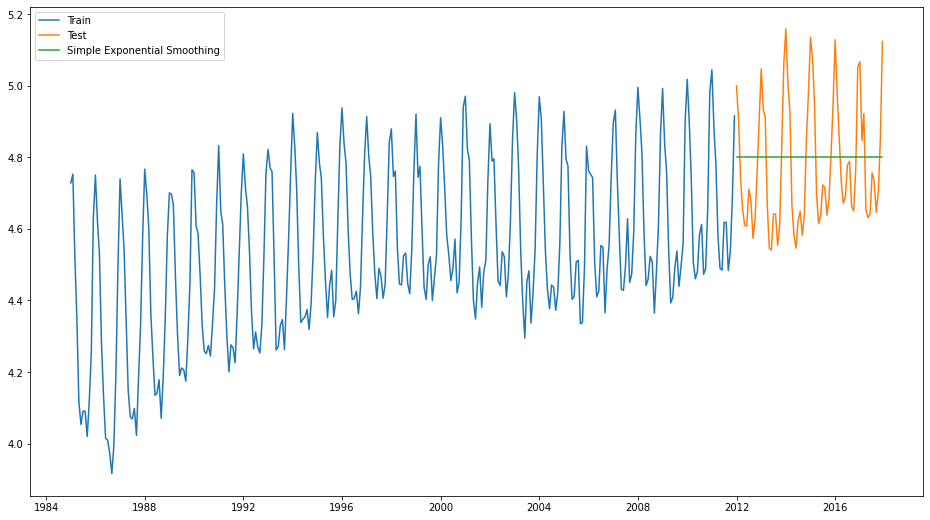

In [ ]:
sesModel = SimpleExpSmoothing(train['Log']).fit(smoothing_level=0.6,optimized=True)
ses_forecast_actual = sesModel.predict(start=test.index[0], end=test.index[-1])
fig = plt.figure(figsize = (16,9))
plt.plot(train.index, train['Log'], label='Train')
plt.plot(test.index, test['Log'], label='Test')
plt.plot(ses_forecast_actual.index, ses_forecast_actual, label='Simple Exponential Smoothing')
plt.legend(loc='best')
plt.show()

In [ ]:
#RSME Value
rmse= sqrt(mean_squared_error(test['Log'],ses_forecast_actual))
print(rmse)

0.17293012298277508


In [ ]:
#Back transformed Forecast RMSE Check
btransformed= np.exp(ses_forecast_actual)
rmse= sqrt(mean_squared_error(test['Value'],btransformed))
print(rmse)

21.778563803332002


**Holt-Winter's Seasonal Additive Model**

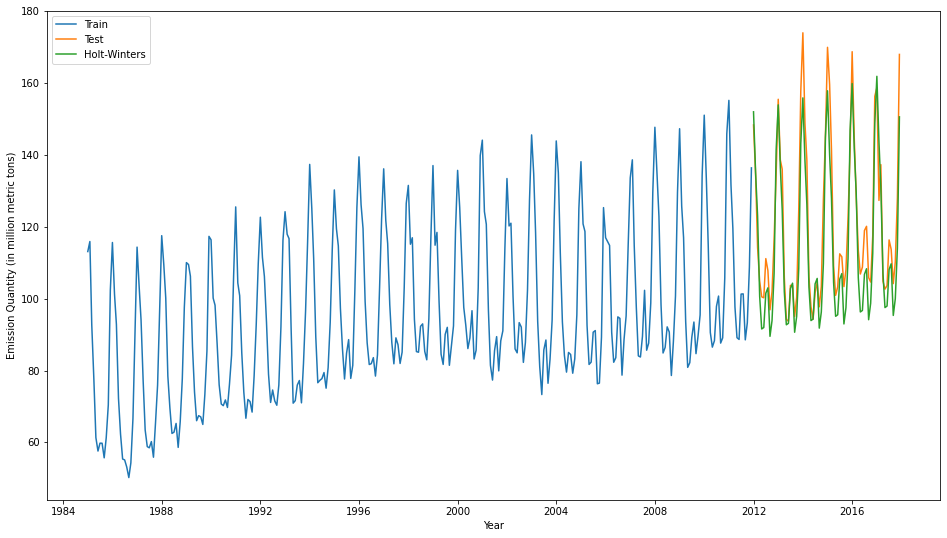

In [ ]:
holtModel = ExponentialSmoothing(train['Log'],trend='additive',seasonal='additive', seasonal_periods=12).fit()
holt_forecast_actual = holtModel.predict(start=test.index[0], end=test.index[-1])
btransformed_holt= np.exp(holt_forecast_actual)
fig = plt.figure(figsize = (16,9))
plt.plot(train.index, train['Value'], label='Train')
plt.plot(test.index, test['Value'], label='Test')
plt.plot(holt_forecast_actual.index, btransformed_holt, label='Holt-Winters')
plt.xlabel("Year")
plt.ylabel("Emission Quantity (in million metric tons)")
plt.legend(loc='best')
plt.show()


In [ ]:
#RSME Value
rmse= sqrt(mean_squared_error(test['Log'],holt_forecast_actual))
print(rmse)

0.07398972227047594


In [ ]:
#Back transformin
rmse= sqrt(mean_squared_error(test['Value'],btransformed_holt))
print(rmse)

8.897380882833925


**Making Path for Seasonal ARIMA Model**

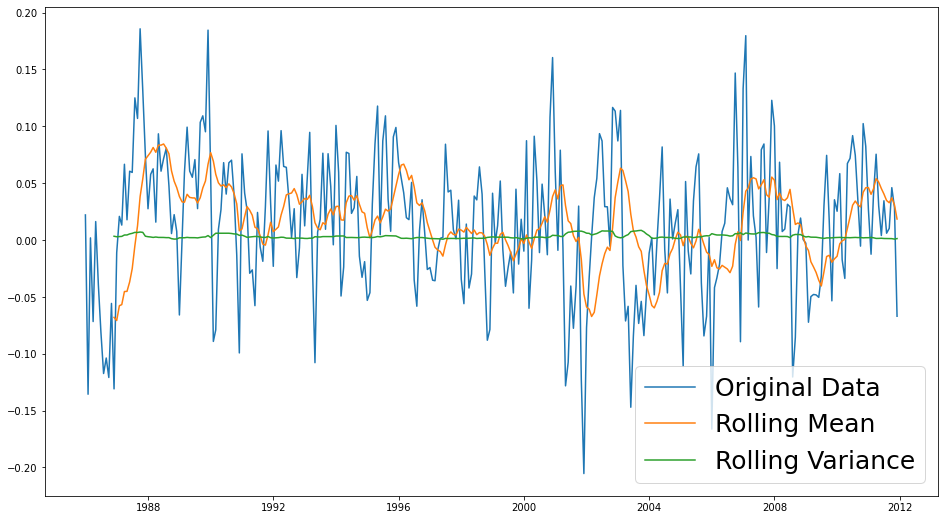

In [ ]:
train['seasonal_difference']=train['Log']-train['Log'].shift(12)
train['seasonal_difference'].dropna(inplace=True)
train['Rmean'] = train['seasonal_difference'].rolling(12).mean()
train['Rstdv'] = train['seasonal_difference'].rolling(12).var()
train['Rstdv'].replace(np.nan,0)
train['Rmean'].replace(np.nan,0)
fig = plt.figure(figsize = (16,9))
plt.plot(train.index,train['seasonal_difference'],label='Original Data')
plt.plot(train.index,train['Rmean'],label='Rolling Mean')
plt.plot(train.index,train['Rstdv'],label='Rolling Variance')
plt.legend(loc='best', fontsize = 25)
plt.show() 

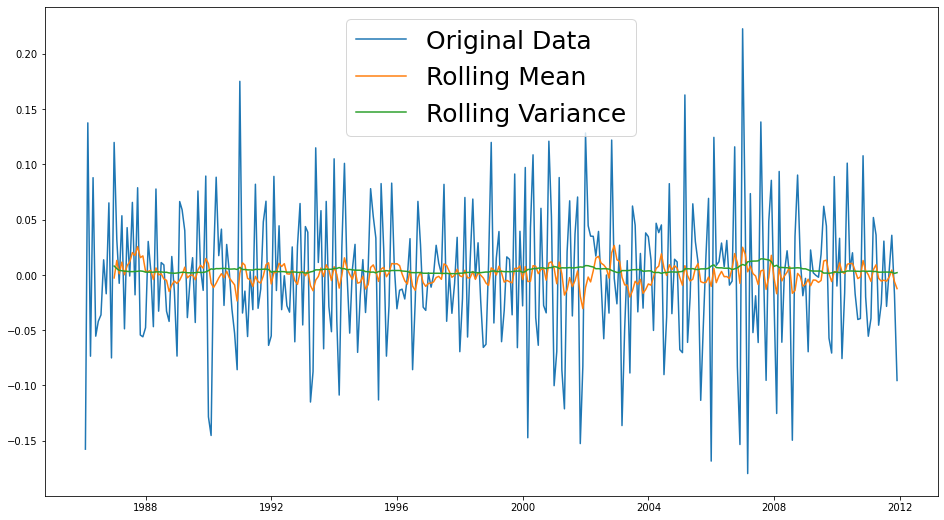

In [ ]:
train['seasonal_first_difference']=train['seasonal_difference']-train['seasonal_difference'].shift(1)
train["seasonal_first_difference"].dropna(inplace=True)
train['Rmean'] = train['seasonal_first_difference'].rolling(12).mean()
train['Rstdv'] = train['seasonal_first_difference'].rolling(12).var()
train['Rstdv'].replace(np.nan,0)
train['Rmean'].replace(np.nan,0)
fig = plt.figure(figsize = (16,9))
plt.plot(train.index,train['seasonal_first_difference'],label='Original Data')
plt.plot(train.index,train['Rmean'],label='Rolling Mean')
plt.plot(train.index,train['Rstdv'],label='Rolling Variance')
plt.legend(loc='best', fontsize = 25)
plt.show()

In [ ]:
check_stationarity_KPSSTest(train['seasonal_first_difference'].dropna())

Test Statistic            0.035671
p-value                   0.100000
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [ ]:
check_stationarity_ADFTest(train['seasonal_first_difference'].dropna())

Test Statistic                -7.187493e+00
p-value                        2.554227e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.940000e+02
Critical Value (1%)           -3.452790e+00
Critical Value (5%)           -2.871422e+00
Critical Value (10%)          -2.572035e+00
dtype: float64


**Result:**<br>
 The results of ADF and KPSS test along with visual inspection using Graph suggest that after seasonal differencing followed by first order differencing we attain stationarity of times series.

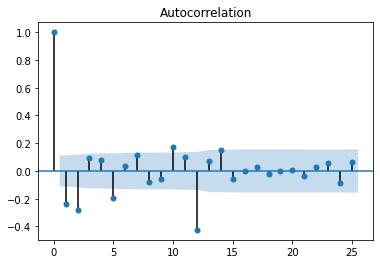

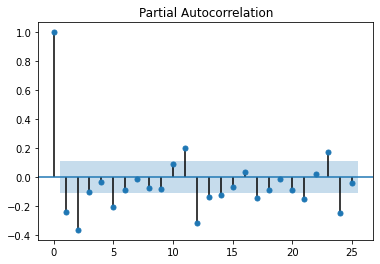

In [ ]:
plotACF(train['seasonal_first_difference'].dropna())
plotPACF(train['seasonal_first_difference'].dropna())

**Findings:**<br>
From these above ACF and PACF plot we can find the values of non-seasonal component and Seasonal Component of ARIMA.
Here our findings suggest that p=2,d=1,q=0 and P=0,D=1,Q=1,m=12 would be appropriate to train the SARIMA Model.

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
SARIMA_Model=SARIMAX(train['Log'], order=(2, 1, 0), seasonal_order=(0, 1, 1, 12), enforce_invertibility=True, enforce_stationarity=True)
results = SARIMA_Model.fit()
forecast_sarima = results.predict(start=test.index[0], end=test.index[-1])
btransformed_arima= np.exp(forecast_sarima)
rmse= sqrt(mean_squared_error(test['Value'],btransformed_arima))
print("RMSE Value",rmse)

RMSE Value 9.668135516931324


In [ ]:
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  Log   No. Observations:                  324
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 501.129
Date:                              Sat, 27 Feb 2021   AIC                           -994.258
Time:                                      04:30:10   BIC                           -979.299
Sample:                                  01-01-1985   HQIC                          -988.278
                                       - 12-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2711      0.046     -5.852      0.000      -0.362      -0.180
ar.L2         -0.28

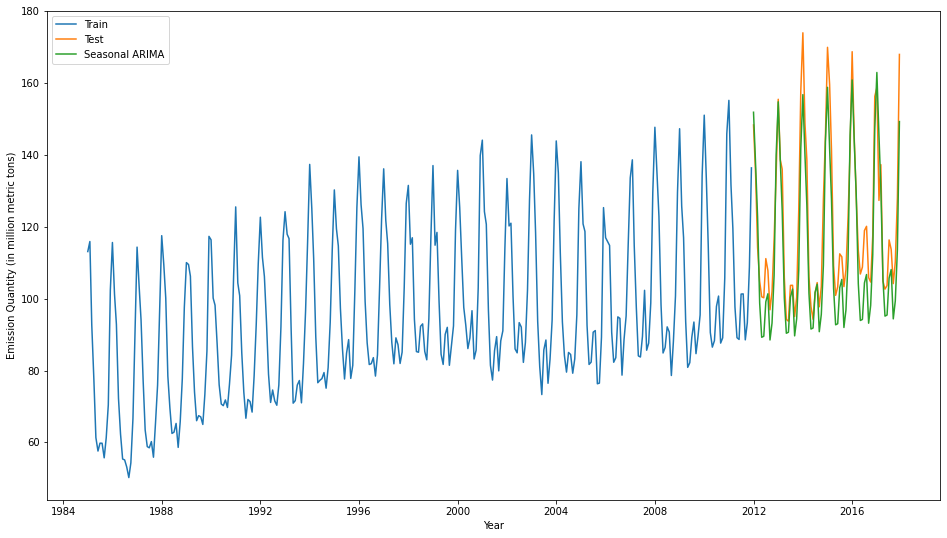

In [ ]:
fig = plt.figure(figsize = (16,9))
plt.plot(train.index, train['Value'], label='Train')
plt.plot(test.index, test['Value'], label='Test')
plt.plot(forecast_sarima.index, btransformed_arima, label='Seasonal ARIMA')
plt.xlabel("Year")
plt.ylabel("Emission Quantity (in million metric tons)")
plt.legend(loc='best')
plt.show()

On the comparing the RMSE values of Simple Exponential Smoothing Method, Holt-Winter Additive Method and Seasonal ARIMA Model(base model defined by our own understanding of p,d,q & P,D,Q Values) we can say the Holt Winter's Prediction on test data is more appropriate by comparing the RMSE value.

We can also check the residual values of the above trained model to confirm that there is some more information left in the residual.

In [ ]:
#For SARIMA
fittedValues_sarima = results.predict(start=train.index[0], end=train.index[-1])
btransformed_fitted_sarima= np.exp(fittedValues_sarima)
residuals_sarima= train['Value']- btransformed_fitted_sarima

In [ ]:
print(residuals_sarima.mean())

-2.7922287462396547


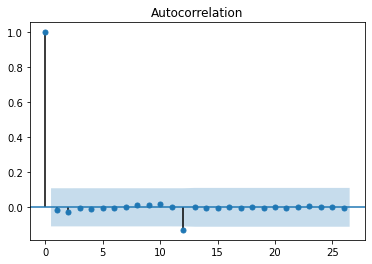

In [ ]:
plotACF(residuals_sarima)

 **Conclusions:**

*   From above 2 results we can see that mean of residuals is not close to zero, although residuals are not auto-correlated.
*   Violation of this one property in residual diagnostics suggest that some more information is left in the timeseries.
*   This can be the plausible reason that Holt Winter's Model is giving more
accurate forecast on test data.
*   We need to find more appropriate values of SARIMA parameters to attain more accurate forecast.



Do not include this

In [ ]:
#For Holt-Winter Model
fittedValues_holt = holtModel.predict(start=train.index[0], end=train.index[-1])
btransformed_fitted_holt= np.exp(fittedValues_holt)
residuals_holt= train['Value']- btransformed_fitted_holt

In [ ]:
print(residuals_holt.mean())

-0.12371492009137486


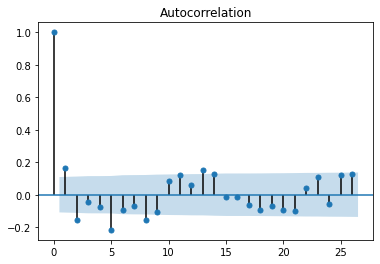

In [ ]:
plotACF(residuals_holt)

do not include till here

**Using GridSearch Method to find the best fit of SARIMA parameters**

In [ ]:
import itertools

p=q=range(0,3)
d=range(1,2)

pdq=list(itertools.product(p,d,q))
seasonal_pdq=[(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
print(seasonal_pdq)
print(pdq)
for i in range(0,9):
  for j in range(0,9):
    print('SARIMAX: {} X {}'.format(pdq[j],seasonal_pdq[j]))

[(0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12)]
[(0, 1, 0), (0, 1, 1), (0, 1, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2)]
SARIMAX: (0, 1, 0) X (0, 1, 0, 12)
SARIMAX: (0, 1, 1) X (0, 1, 1, 12)
SARIMAX: (0, 1, 2) X (0, 1, 2, 12)
SARIMAX: (1, 1, 0) X (1, 1, 0, 12)
SARIMAX: (1, 1, 1) X (1, 1, 1, 12)
SARIMAX: (1, 1, 2) X (1, 1, 2, 12)
SARIMAX: (2, 1, 0) X (2, 1, 0, 12)
SARIMAX: (2, 1, 1) X (2, 1, 1, 12)
SARIMAX: (2, 1, 2) X (2, 1, 2, 12)
SARIMAX: (0, 1, 0) X (0, 1, 0, 12)
SARIMAX: (0, 1, 1) X (0, 1, 1, 12)
SARIMAX: (0, 1, 2) X (0, 1, 2, 12)
SARIMAX: (1, 1, 0) X (1, 1, 0, 12)
SARIMAX: (1, 1, 1) X (1, 1, 1, 12)
SARIMAX: (1, 1, 2) X (1, 1, 2, 12)
SARIMAX: (2, 1, 0) X (2, 1, 0, 12)
SARIMAX: (2, 1, 1) X (2, 1, 1, 12)
SARIMAX: (2, 1, 2) X (2, 1, 2, 12)
SARIMAX: (0, 1, 0) X (0, 1, 0, 12)
SARIMAX: (0, 1, 1) X (0, 1, 1, 12)
SARIMAX: (0, 1, 2) X (0, 1, 2, 12)
SARIMAX: (1, 1, 0) X (1, 1, 0

In [ ]:
metric_aic_dict=dict()

for pm in pdq:
  for pm_seasonal in seasonal_pdq:
    model=sm.tsa.statespace.SARIMAX(train['Log'],order=pm, seasonal_order=pm_seasonal, enforce_stationarity=True, enforce_invertibility=True) 
    model_aic=model.fit()
    print('ARIMA{} X{}12-AICc:{}'.format(pm,pm_seasonal,model_aic.aicc))
    metric_aic_dict.update({(pm,pm_seasonal):model_aic.aicc})

ARIMA(0, 1, 0) X(0, 1, 0, 12)12-AIC:-831.392888155201
ARIMA(0, 1, 0) X(0, 1, 1, 12)12-AIC:-962.1303109885622
ARIMA(0, 1, 0) X(0, 1, 2, 12)12-AIC:-960.0964909327331
ARIMA(0, 1, 0) X(1, 1, 0, 12)12-AIC:-895.1995055101542
ARIMA(0, 1, 0) X(1, 1, 1, 12)12-AIC:-960.0951816393799
ARIMA(0, 1, 0) X(1, 1, 2, 12)12-AIC:-958.7799746803554
ARIMA(0, 1, 0) X(2, 1, 0, 12)12-AIC:-934.2380765992149
ARIMA(0, 1, 0) X(2, 1, 1, 12)12-AIC:-960.6546264880094
ARIMA(0, 1, 0) X(2, 1, 2, 12)12-AIC:-958.0032265761513
ARIMA(0, 1, 1) X(0, 1, 0, 12)12-AIC:-881.9850244066226
ARIMA(0, 1, 1) X(0, 1, 1, 12)12-AIC:-987.360737956827
ARIMA(0, 1, 1) X(0, 1, 2, 12)12-AIC:-985.3596756746488
ARIMA(0, 1, 1) X(1, 1, 0, 12)12-AIC:-945.4680317446046
ARIMA(0, 1, 1) X(1, 1, 1, 12)12-AIC:-985.3518052807101
ARIMA(0, 1, 1) X(1, 1, 2, 12)12-AIC:-983.4783257591059
ARIMA(0, 1, 1) X(2, 1, 0, 12)12-AIC:-968.007055325967
ARIMA(0, 1, 1) X(2, 1, 1, 12)12-AIC:-984.2276136695907
ARIMA(0, 1, 1) X(2, 1, 2, 12)12-AIC:-981.8400306598095
ARIMA(0, 1, 2

In [ ]:
{k: v for k,v in sorted(metric_aic_dict.items(),key=lambda x:x[1])}

{((0, 1, 0), (0, 1, 0, 12)): -831.392888155201,
 ((0, 1, 0), (0, 1, 1, 12)): -962.1303109885622,
 ((0, 1, 0), (0, 1, 2, 12)): -960.0964909327331,
 ((0, 1, 0), (1, 1, 0, 12)): -895.1995055101542,
 ((0, 1, 0), (1, 1, 1, 12)): -960.0951816393799,
 ((0, 1, 0), (1, 1, 2, 12)): -958.7799746803554,
 ((0, 1, 0), (2, 1, 0, 12)): -934.2380765992149,
 ((0, 1, 0), (2, 1, 1, 12)): -960.6546264880094,
 ((0, 1, 0), (2, 1, 2, 12)): -958.0032265761513,
 ((0, 1, 1), (0, 1, 0, 12)): -881.9850244066226,
 ((0, 1, 1), (0, 1, 1, 12)): -987.360737956827,
 ((0, 1, 1), (0, 1, 2, 12)): -985.3596756746488,
 ((0, 1, 1), (1, 1, 0, 12)): -945.4680317446046,
 ((0, 1, 1), (1, 1, 1, 12)): -985.3518052807101,
 ((0, 1, 1), (1, 1, 2, 12)): -983.4783257591059,
 ((0, 1, 1), (2, 1, 0, 12)): -968.007055325967,
 ((0, 1, 1), (2, 1, 1, 12)): -984.2276136695907,
 ((0, 1, 1), (2, 1, 2, 12)): -981.8400306598095,
 ((0, 1, 2), (0, 1, 0, 12)): -908.6382254791479,
 ((0, 1, 2), (0, 1, 1, 12)): -1018.0197046258891,
 ((0, 1, 2), (0, 1, 2,

In [ ]:
SARIMA_Model2=SARIMAX(train['Log'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_invertibility=True, enforce_stationarity=True)
results2 = SARIMA_Model2.fit()
forecast_sarima2 = results2.predict(start=test.index[0], end=test.index[-1])
btransformed_arima2= np.exp(forecast_sarima2)
rmse2= sqrt(mean_squared_error(test['Value'],btransformed_arima2))
print(rmse2)

9.314761072642844


In [ ]:
print(results2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                Log   No. Observations:                  324
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 515.476
Date:                            Sat, 27 Feb 2021   AIC                          -1022.953
Time:                                    04:28:27   BIC                          -1007.993
Sample:                                01-01-1985   HQIC                         -1016.973
                                     - 12-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5143      0.059      8.736      0.000       0.399       0.630
ma.L1         -0.9396      0.028   

**Comparing forecast of previously trained models on test set. <br>Models:<br> Holt Winter's Model <br>
        Seasonal ARIMA (2,1,0)(0,1,1) m=12<br>
        Seasonal ARIMA (1,1,1)(0,1,1) m=12**


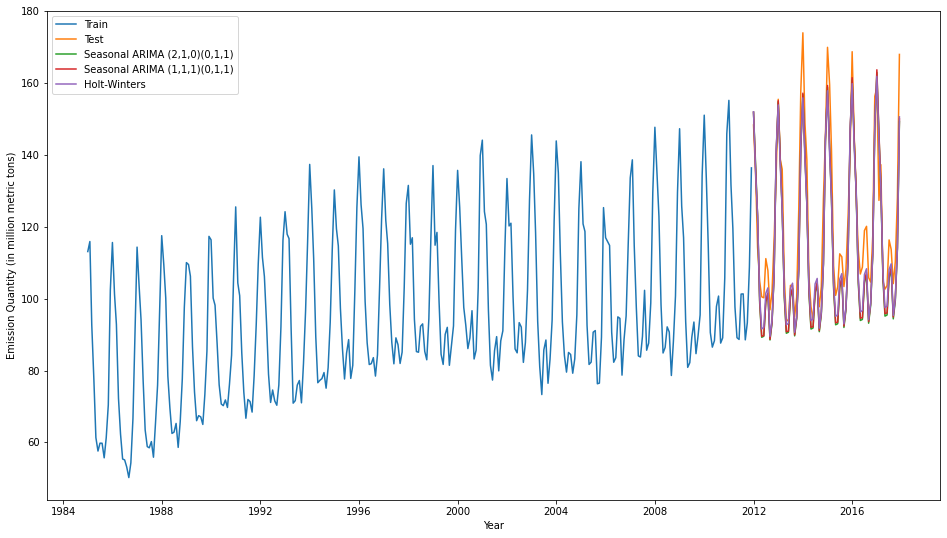

In [ ]:
fig = plt.figure(figsize = (16,9))
plt.plot(train.index, train['Value'], label='Train')
plt.plot(test.index, test['Value'], label='Test')
plt.plot(forecast_sarima.index, btransformed_arima, label='Seasonal ARIMA (2,1,0)(0,1,1)')
plt.plot(forecast_sarima.index, btransformed_arima2, label='Seasonal ARIMA (1,1,1)(0,1,1)')
plt.plot(holt_forecast_actual.index, btransformed_holt, label='Holt-Winters')
plt.xlabel("Year")
plt.ylabel("Emission Quantity (in million metric tons)")
plt.legend(loc='best')
plt.show()

**Final Forecasting of emission for the year 2018-20 using Holt-Winter's Seasonal Additive Model**



In [ ]:
new_train= Energy_source_NaturalGas_New.iloc[:396]

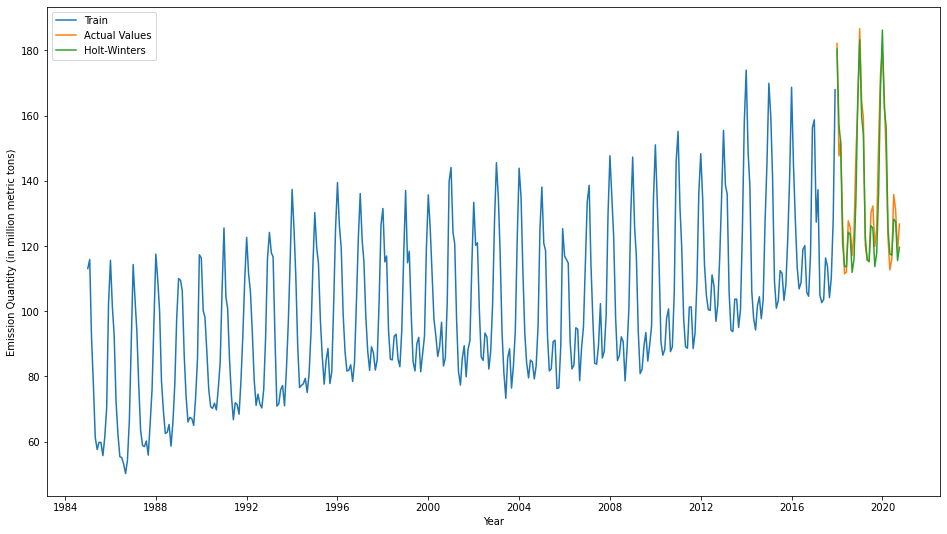

In [ ]:
holtModel_ff = ExponentialSmoothing(new_train['Log'],trend='additive',seasonal='additive', seasonal_periods=12).fit()
holt_forecast_ff = holtModel_ff.predict(start=forecast_validate.index[0], end=forecast_validate.index[-1])
btransformed_holt_ff= np.exp(holt_forecast_ff)
fig = plt.figure(figsize = (16,9))
plt.plot(new_train.index, new_train['Value'], label='Train')
plt.plot(forecast_validate.index, forecast_validate['Value'], label='Actual Values')
plt.plot(holt_forecast_ff.index, btransformed_holt_ff, label='Holt-Winters')
plt.xlabel("Year")
plt.ylabel("Emission Quantity (in million metric tons)")
plt.legend(loc='best')
plt.show()

In [ ]:
#Checking Forecast metric for year 2018-20
rmse= sqrt(mean_squared_error(forecast_validate['Value'],btransformed_holt_ff))
print(rmse)

6.024206537591921


**Conclusion**:

---
The best model was chosen as Holt-Winter's Model to forecast the Co2 emissions for the year 2018-20.<br>
After training the model on entire dataset(train+test orginally),the model forecasted the values with RMSE value of 6.0242, which is the lowest any model has acheived in our entire analysis.
